In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 4: Problem 3 (p43)

## Physics Constants

In [2]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Wavelength: 0.9993 m
K0^2: 39.5331 1/m


## 3-noded Linear Triangular Elements, $P_1$

In [3]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 'ur': 1, 'er': 1},
            {'tag': 301, 'name': 'PML_a','ur': 1, 'er': 1},
            {'tag': 302, 'name': 'PML_b','ur': 1, 'er': 1},
            {'tag': 303, 'name': 'PML_c','ur': 1, 'er': 1},
            {'tag': 304, 'name': 'PML_d','ur': 1, 'er': 1},
            {'tag': 401, 'name': 'PML_I','ur': 1, 'er': 1},
            {'tag': 402, 'name': 'PML_II','ur': 1, 'er': 1},
            {'tag': 403, 'name': 'PML_III','ur': 1, 'er': 1},
            {'tag': 404, 'name': 'PML_IV','ur': 1, 'er': 1}]

# Criar geometria coaxial
GEOMETRY = {'h': WAVELENGTH/25, 'L': WAVELENGTH*0.4, 'ra': WAVELENGTH*0.5, 'x0': 1.0*WAVELENGTH}
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, GEOMETRY, view_mesh=False)

# Parâmetros da PML
PML_DESIGN = {
    'x0': GEOMETRY['x0'],   # Interface inicial do PML
    'n': 1.0,               # Ordem polinomial do PML
    'R': 1E-4,              # Coeficiente de reflexão
}

# Aplicar a física do problema
mesh_data = ps.apply_pml_physics(PML_DESIGN, mesh_data)

Malha salva em pre_processing/mesh/rectangular_pml_domain_Triangle1.msh
Model rectangular_pml (2D)
Info     : 51 geometric entities
Info     : 10 Physical Groups
Info     : 5478 nodes in total
Info     : 10597 2-D elements in total


## Figure 1: Meshed at $\Omega_c$ domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p43_vectorial_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


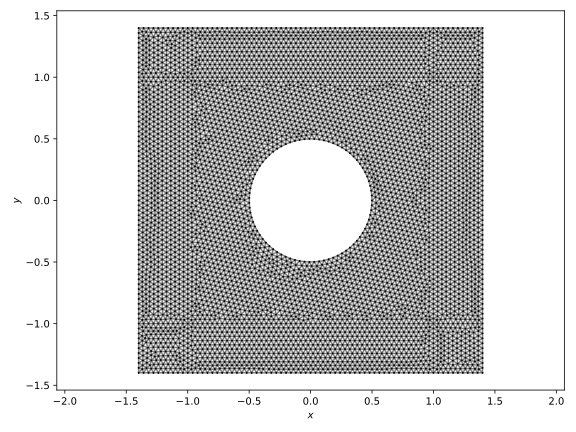

In [4]:
INFO_GRAPH = {'cell': False, 'nodes': False, 'edges': False, 'edges_numb': False}
graph_results.plot_mesh(FINITE_ELEMENT, INFO_GRAPH, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## `pml_global_reduced_matrices()`

In [5]:
import numpy as np
from scipy.sparse import lil_matrix
from fem_processing import gaussian_quadrature
from fem_processing import master_domain

# Arestas livres
free_edges = {key: value
                for key, value in mesh_data['edges'].items() if value['bc']['type'] != 'Dirichlet'}

# Mapeamento de índices globais para índices reduzidos
global_to_reduced = {global_edge: idx
                        for idx, global_edge in enumerate(free_edges.keys())}

# Initialize the global matrix and vector
Sgr = lil_matrix((len(free_edges), len(free_edges)), dtype='complex128')
Mgr = lil_matrix((len(free_edges), len(free_edges)), dtype='complex128')
bgr = lil_matrix((len(free_edges), 1), dtype='complex128')

## `assembly.local_matrices()`

In [6]:
for cell in mesh_data['cell'].values():
    Ne = len(cell['conn_edge'])
    Me = np.zeros((Ne, Ne), dtype='complex128') # Matriz de massa do elemento
    be = np.zeros((Ne, 1), dtype='complex128')  # Vetor de carga do elemento

    # Cálculo da matriz Jacobiana
    # Je = assembly.jacobian(mesh_data, cell)
    Je = cell['geo']['jacobian']
    Jdet, JinvT = np.abs(np.linalg.det(Je)), np.linalg.inv(Je).T  

    # Material properties
    pe = cell['p(x)']
    qe = cell['q(x)']
    fe = cell['f(x)']

    # Matriz de rigidez do elemento
    Se = pe * (2 / Jdet) * np.array([
        [1, -1, 1], 
        [-1, 1, -1],
        [1, -1, 1]
    ])

    # Get the Gauss points and weights
    gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)
    for xik, wk in zip(gauss_points, gauss_weights):
        # Função de forma vetorial no ponto de integração
        phi_hat = master_domain.shape_functions_nedelec(*xik)

        # Montagem da matriz de massa
        for i in range(Ne):
            # Transformação de Piola Covariante
            phi_i = qe @ (JinvT @ phi_hat[i])
            for j in range(Ne):
                # Matriz de massa
                Me[i, j] += (phi_i.T @ JinvT @ phi_hat[j]).item() * Jdet * wk

    for i, ig in enumerate(cell['conn_edge']):
        if ig in free_edges:
            ig_red = global_to_reduced[ig]                        
            for j, jg in enumerate(cell['conn_edge']):
                if jg in free_edges:
                    jg_red = global_to_reduced[jg]
                    Sgr[ig_red, jg_red] += Se[i, j]
                    Mgr[ig_red, jg_red] += Me[i, j]

                # A aresta global é de Dirichlet
                else:
                    # Contribuição de Dirichlet para o vetor reduzido
                    bgr[ig_red, 0] += -(Se[i, j] + Me[i, j]) * mesh_data['edges'][jg]['bc']['value']
            
            # preenche o vetor global de carga
            bgr[ig_red, 0] += be[i]

## `fem_solution`

In [7]:
curl_uhr = spsolve((Sgr + Mgr).tocsr(), bgr.toarray())

## `assembly.global_potentials()`

In [8]:
# Preenche o vetor solução
curl_uh = {}
for key, edge in mesh_data['edges'].items():
    # Verifica se a aresta é livre
    if key in free_edges:
        # Mapeamento global para reduzido
        curl_uh[int(key)] = curl_uhr[global_to_reduced[key]]

    # Nó de Dirichlet
    else:
        curl_uh[int(key)] = edge['bc']['value']

## Interpolate solution at computacional domain

In [9]:
# Dicionário para armazenar os potenciais vetoriais interpolados em cada célula
ush_at_cell, uth_at_cell = {}, {}
xik_master = (1/3, 1/3)

# Percorre cada célula da malha
for key, cell in mesh_data['cell'].items():    
    Je = cell['geo']['jacobian']    
    JinvT = np.linalg.inv(Je).T
    phi_hat = master_domain.shape_functions_nedelec(*xik_master)

    # Interpolação dos potenciais vetoriais em cada célula
    ush_at_cell[key] = 0
    for i, edge in enumerate(cell['conn_edge']):
        ush_at_cell[key] += curl_uh[edge] * (JinvT @ phi_hat[i])

    # Campo total
    uth_at_cell[key] = cell['ui(x)'] + ush_at_cell[key]

## Figure 2: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

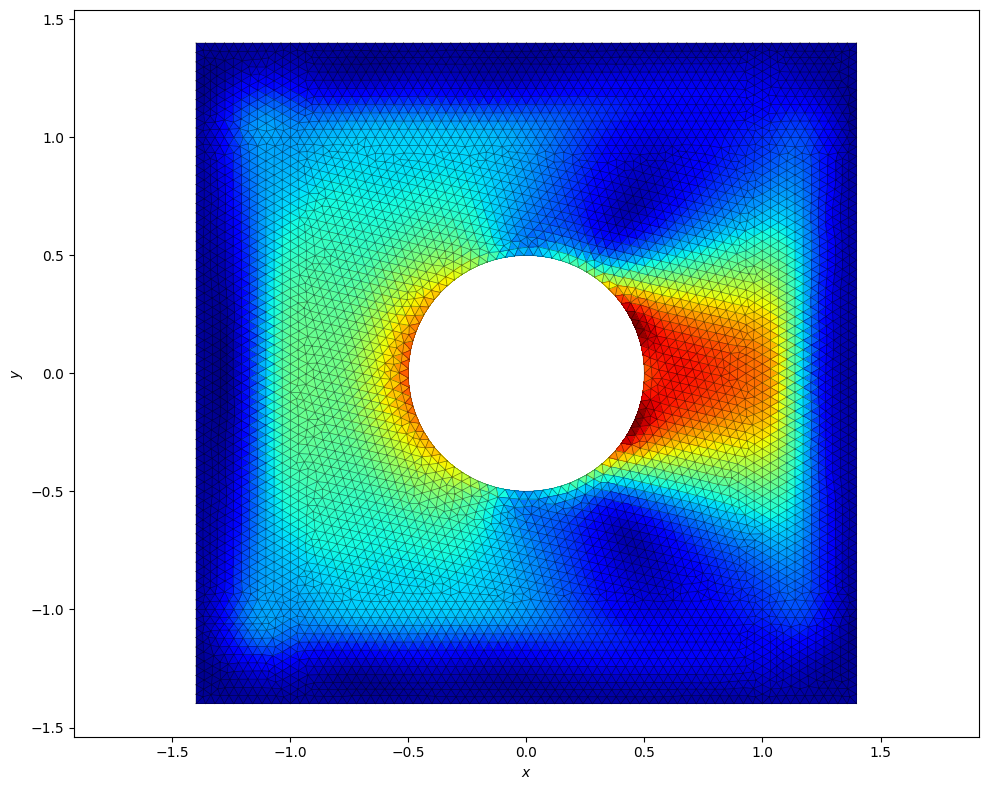

In [10]:
import matplotlib.pyplot as plt

ush_norm = [np.linalg.norm(uhs) for uhs in ush_at_cell.values()]
uth_norm = [np.linalg.norm(uht) for uht in uth_at_cell.values()]

# Extraindo as coordenadas globais dos nós (x, y) e a matriz de conectividade
xg, yg, conn_py = graph_results.structured_data(mesh_data)

# Criando a malha
plt.figure(figsize=(10, 8))

# Plotando a solução numérica sobre a malha com `tripcolor`
plt.tripcolor(xg, yg, conn_py, facecolors=uth_norm, cmap='jet', shading='flat')

# Adicionando a malha para visualização (opcional)
plt.triplot(xg, yg, conn_py, color='black', linewidth=0.5, alpha=0.5)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.axis('equal')
plt.show()

## Figure 3: Meshed Physical Domain, $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p43_vectorial_circular_pec_scatterer_pml\pre_processing\pictures\meshed_physical_domain_Triangle1_EntireDomain.svg


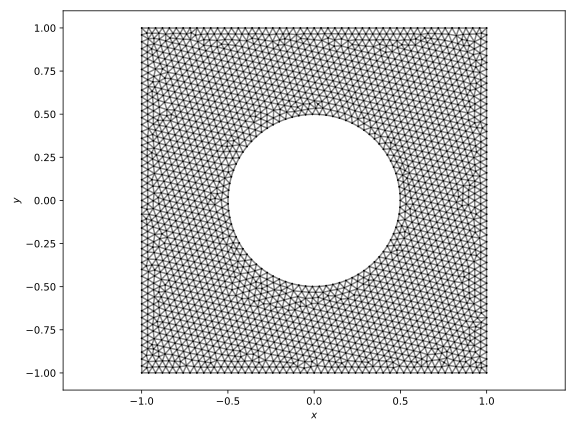

In [11]:
physical_mesh_data = ps.get_physical_mesh_data(mesh_data)
ps.plot_physical_mesh(FINITE_ELEMENT, INFO_GRAPH, mesh_data, physical_mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_physical_domain_Triangle1_EntireDomain.svg"))

In [12]:
ush_at_phy_cell = {key: ush_at_cell[key] for key in physical_mesh_data['cell'].keys()}
ush_phy_norm = [np.linalg.norm(uhs) for uhs in ush_at_phy_cell.values()]

In [13]:
def physical_structured_data(physical_mesh_data):
    # Extrair coordenadas dos nós físicos
    xg_phy = [node['xg'][0] for node in physical_mesh_data['nodes'].values()]
    yg_phy = [node['xg'][1] for node in physical_mesh_data['nodes'].values()]

    # Recriar conectividade com índices ajustados
    conn_py_phy = [[node - 1 for node in cell['conn_physical'][:3]]
                    for cell in physical_mesh_data['cell'].values()]
    
    return xg_phy, yg_phy, conn_py_phy

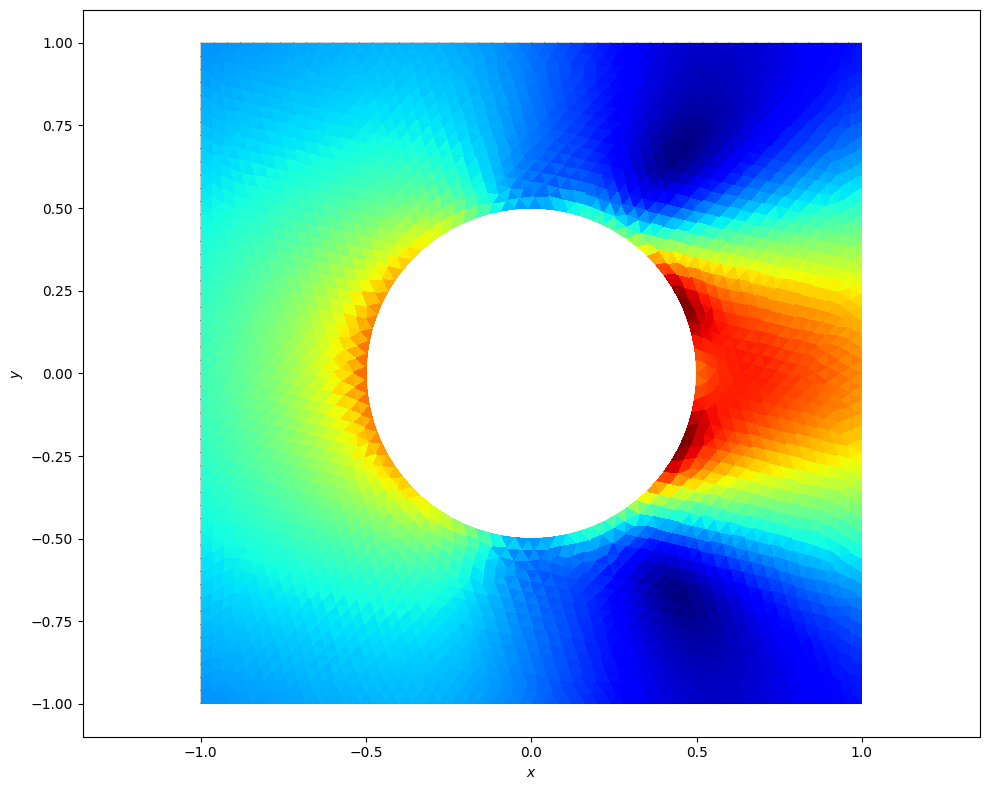

In [14]:
import matplotlib.pyplot as plt

# Extraindo as coordenadas globais dos nós (x, y) e a matriz de conectividade
xg_phy, yg_phy, conn_py_phy = physical_structured_data(physical_mesh_data)

# Criando a malha
plt.figure(figsize=(10, 8))

# Adicionando a malha para visualização (opcional)
plt.triplot(xg_phy, yg_phy, conn_py_phy, color='black', linewidth=0.5, alpha=0.5)

# Plotando a solução numérica sobre a malha com `tripcolor`
plt.tripcolor(xg_phy, yg_phy, conn_py_phy, facecolors=ush_phy_norm, cmap='jet', shading='flat')

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.axis('equal')
plt.show()

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.